In [10]:
import sys
sys.path.append("..")
from utils import HopfieldNet, Flatten
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from utils import entmax
from collections import Counter
import numpy as np

In [4]:
from lpsmap.ad3qp.factor_graph import PFactorGraph
from lpsmap import TorchFactorGraph, Pair, Budget
from lpsmap import Sequence, SequenceBudget
from lpsmap.ad3ext.sequence import PFactorSequence

def SparseMAP_exactly_k(scores, k=2):
    marginals = torch.zeros_like(scores)
    for j in range(scores.shape[1]):
        fg = TorchFactorGraph()
        u = fg.variable_from(scores[:, j])
        fg.add(Budget(u, k, force_budget=True))
        fg.solve(verbose=0)
        marginals[:, j] = u.value[:]
    return marginals

def SparseMAP_sequence_exactly_k(scores, edge_score, k=2):
    n = scores.shape[0]
    transition = torch.zeros((n+1,2,2), requires_grad=True)
    transition.data[1:n, 0, 0] = edge_score
    # Only one state in the beginning and in the end for start / stop symbol.
    transition = transition.reshape(-1)[2:-2]
    marginals = torch.zeros_like(scores)
    for j in range(scores.shape[1]):
        s = torch.zeros((n, 2))
        s[:, 0] = scores[:, j]
        fg = TorchFactorGraph()
        u = fg.variable_from(s)
        fg.add(SequenceBudget(u, transition, k, force_budget=True))
        fg.solve(verbose=0)
        marginals[:, j] = u.value[:, 0]
    return marginals

import time
tic = time.time()
for i in range(1000):
    print(i)
    scores = torch.randn(60000, 1)
    marginals = SparseMAP_exactly_k(scores, k=2)
    #print(marginals[:, 0].argsort()[-10:])
print(time.time() - tic)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


KeyboardInterrupt: 

In [6]:
def accuracy(gt, predicted):
    correct_predictions = (gt == predicted).sum().item()

    # Calculate the total number of samples (length of the tensors)
    total_samples = len(gt)

    # Calculate the percentage of correct values
    accuracy = (correct_predictions / total_samples) * 100.0

    return accuracy

In [7]:
torch.random.manual_seed(42)

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
    Flatten()  # Normalize to [-1, 1]
])

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='../datasets', train=True, download=False, transform=transform)
mnist_dataset_test = datasets.MNIST(root='../datasets', train=False, download=False, transform=transform)

# Create a DataLoader to iterate over the dataset
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=len(mnist_dataset), shuffle=True)
# Create a DataLoader to iterate over the dataset
data_loader_test = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=len(mnist_dataset_test), shuffle=True)

for data in data_loader:
    X_train, labels_train = data

for data in data_loader_test:
    X_test, labels_test = data

In [8]:
#Train
# Create a one-hot encoded label matrix
num_classes = 10  # Assuming you have 10 classes (adjust as needed)

# Perform one-hot encoding
one_hot_encoded = torch.zeros(len(labels_train), num_classes)
one_hot_encoded.scatter_(1, labels_train.view(-1, 1), 1)
one_hot_encoded = one_hot_encoded

# Add the one-hot encoded vectors to 'X'
X_train = torch.cat((X_train, one_hot_encoded), dim=1)

#Test
# Perform one-hot encoding
one_hot_encoded = torch.zeros(len(labels_test), num_classes)
one_hot_encoded.scatter_(1, labels_test.view(-1, 1), 1)
one_hot_encoded = one_hot_encoded

# Add the one-hot encoded vectors to 'X'
X_test = torch.cat((X_test, one_hot_encoded), dim=1)

X_stored = X_train

In [9]:
def entmax_predictions(X_stored, X_test, beta, labels, device="1"):
    device = torch.device("cuda:" + device)

    # Move your data tensors to the GPU
    X_stored = X_stored.to(device)
    X_test = X_test.to(device)

    # Create the HopfieldNet models on the GPU
    model_softmax = HopfieldNet(X_stored, 1.0, beta, 128).to(device)
    model_entmax = HopfieldNet(X_stored, 1.5, beta, 128).to(device)
    model_sparsemax = HopfieldNet(X_stored, 2.0, beta, 128).to(device)

    # Run the models on the GPU
    Q_softmax = model_softmax(X_test.T)
    Q_entmax = model_entmax(X_test.T)
    Q_sparsemax = model_sparsemax(X_test.T)

    # Move the results back to the CPU (if needed)
    Q_softmax = Q_softmax.to("cpu")
    Q_entmax = Q_entmax.to("cpu")
    Q_sparsemax = Q_sparsemax.to("cpu")

    # Perform other operations on CPU, e.g., calculate accuracy
    predicted_softmax = torch.argmax(Q_softmax.T[:, -10:], dim=1)
    predicted_entmax = torch.argmax(Q_entmax.T[:, -10:], dim=1)
    predicted_sparsemax = torch.argmax(Q_sparsemax.T[:, -10:], dim=1)

    accuracy_softmax = accuracy(labels, predicted_softmax)
    accuracy_entmax = accuracy(labels, predicted_entmax)
    accuracy_sparsemax = accuracy(labels, predicted_sparsemax)

    print(f"Beta: {beta:.5f}")
    print(f"Softmax accuracy: {accuracy_softmax:.5f}%")
    print(f"Entmax accuracy: {accuracy_entmax:.5f}%")
    print(f"Sparsemax accuracy: {accuracy_sparsemax:.5f}%\n")

    return accuracy_softmax, accuracy_entmax, accuracy_sparsemax


In [11]:
#Compute accuracies for different betas
betas = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
a_softmax = []
a_entmax = []
a_sparsemax = []

for beta in betas:
    accuracy_softmax, accuracy_entmax, accuracy_sparsemax = entmax_predictions(X_stored, X_test, beta, labels_test)
    a_softmax.append(accuracy_softmax)  
    a_entmax.append(accuracy_entmax)
    a_sparsemax.append(accuracy_sparsemax)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.24 GiB. GPU 1 has a total capacty of 11.91 GiB of which 1.98 GiB is free. Process 98803 has 687.00 MiB memory in use. Process 98848 has 665.00 MiB memory in use. Process 98846 has 687.00 MiB memory in use. Process 98889 has 687.00 MiB memory in use. Process 98839 has 665.00 MiB memory in use. Process 98853 has 665.00 MiB memory in use. Process 98762 has 665.00 MiB memory in use. Including non-PyTorch memory, this process has 5.32 GiB memory in use. Of the allocated memory 2.48 GiB is allocated by PyTorch, and 2.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

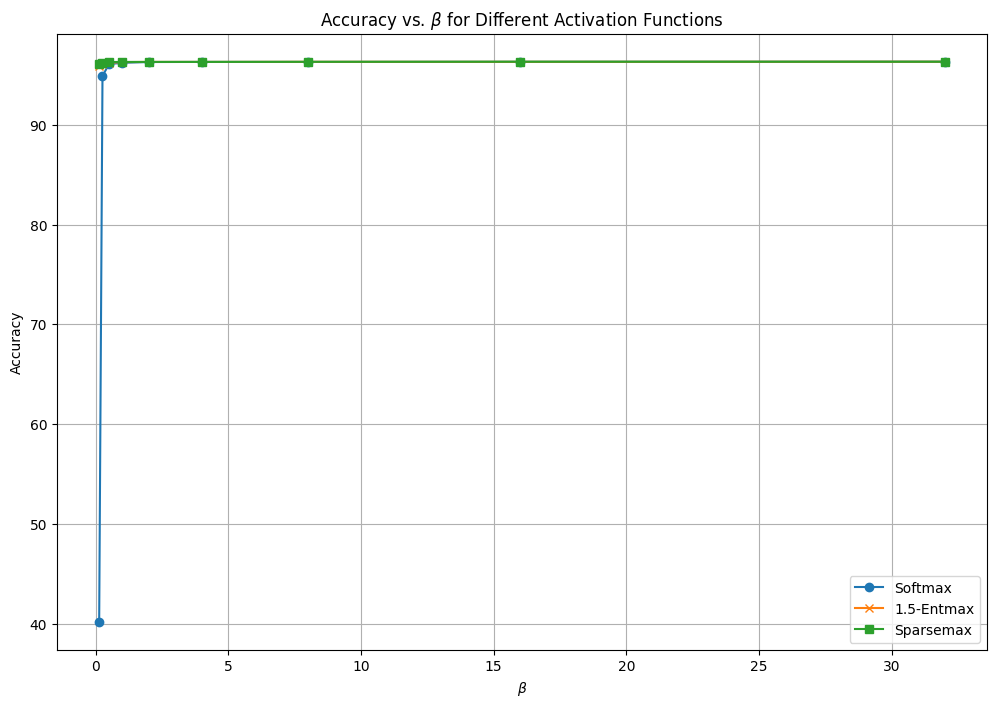

In [146]:
#Plots of accuracy vs beta
# Create a Matplotlib figure
plt.figure(figsize=(12, 8))

# Plot Softmax accuracy
plt.plot(betas, a_softmax, label='Softmax', marker='o')

# Plot Entmax accuracy
plt.plot(betas, a_entmax, label='1.5-Entmax', marker='x')

# Plot Sparsemax accuracy
plt.plot(betas, a_sparsemax, label='Sparsemax', marker='s')

# Set labels and title
plt.xlabel('$\\beta$')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. $\\beta$ for Different Activation Functions')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [147]:
#---------------------------Accuracy vs dataset size-----------------------------------

idxs = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 60000]
beta = 8
a_vd_softmax = []
a_vd_entmax = []
a_vd_sparsemax = []

for idx in idxs:

    X_stored = X_train[:idx-1]
    print(f"Dataset size: {idx:.1f}")
    
    accuracy_softmax, accuracy_entmax, accuracy_sparsemax = entmax_predictions(X_stored, X_test, beta, labels_test, "3")
    a_vd_softmax.append(accuracy_softmax)  
    a_vd_entmax.append(accuracy_entmax)
    a_vd_sparsemax.append(accuracy_sparsemax)
    
    

Dataset size: 128.0
Beta: 8.00000
Softmax accuracy: 69.47000%
Entmax accuracy: 69.47000%
Sparsemax accuracy: 69.47000%

Dataset size: 256.0
Beta: 8.00000
Softmax accuracy: 75.83000%
Entmax accuracy: 75.83000%
Sparsemax accuracy: 75.85000%

Dataset size: 512.0
Beta: 8.00000
Softmax accuracy: 81.55000%
Entmax accuracy: 81.55000%
Sparsemax accuracy: 81.56000%

Dataset size: 1024.0
Beta: 8.00000
Softmax accuracy: 87.29000%
Entmax accuracy: 87.29000%
Sparsemax accuracy: 87.29000%

Dataset size: 2048.0
Beta: 8.00000
Softmax accuracy: 90.28000%
Entmax accuracy: 90.28000%
Sparsemax accuracy: 90.28000%

Dataset size: 4096.0
Beta: 8.00000
Softmax accuracy: 92.53000%
Entmax accuracy: 92.53000%
Sparsemax accuracy: 92.53000%

Dataset size: 8192.0
Beta: 8.00000
Softmax accuracy: 93.71000%
Entmax accuracy: 93.72000%
Sparsemax accuracy: 93.72000%

Dataset size: 16384.0
Beta: 8.00000
Softmax accuracy: 95.16000%
Entmax accuracy: 95.16000%
Sparsemax accuracy: 95.16000%

Dataset size: 32768.0
Beta: 8.0000

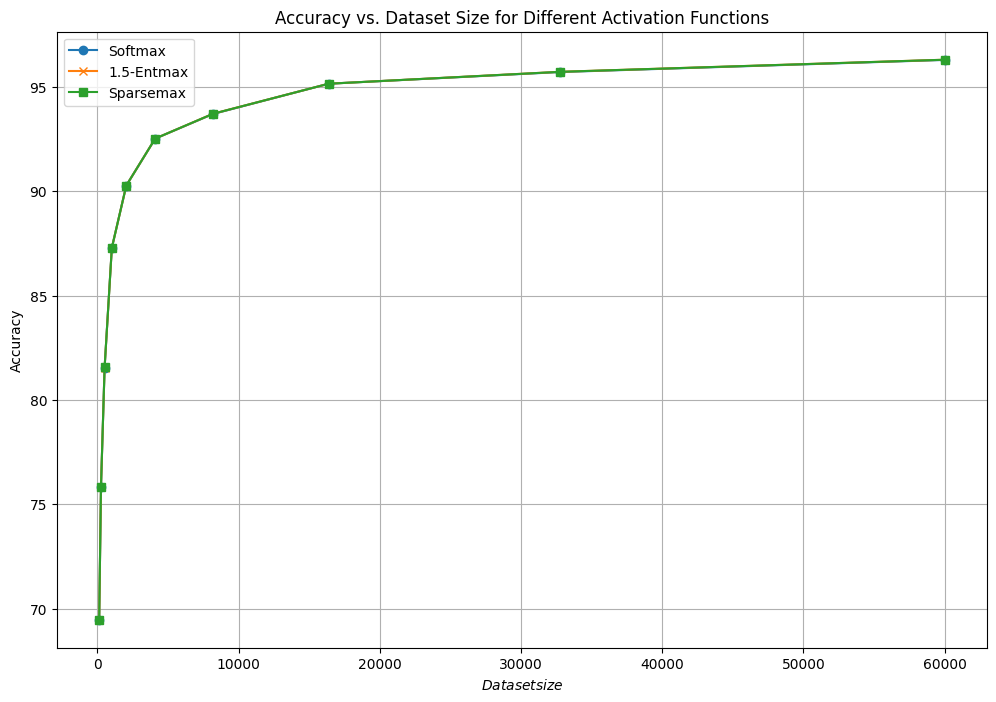

In [148]:
#Plots of accuracy vs beta
# Create a Matplotlib figure
plt.figure(figsize=(12, 8))

# Plot Softmax accuracy
plt.plot(idxs, a_vd_softmax, label='Softmax', marker='o')

# Plot Entmax accuracy
plt.plot(idxs, a_vd_entmax, label='1.5-Entmax', marker='x')

# Plot Sparsemax accuracy
plt.plot(idxs, a_vd_sparsemax, label='Sparsemax', marker='s')

# Set labels and title
plt.xlabel('$Dataset  size$')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Dataset Size for Different Activation Functions')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

Retrieval Evaluation

In [ ]:
def add_gaussian_noise(image, mean=0, std=1):
    # Generate Gaussian noise with the same shape as the image
    noise = torch.randn(image.size()) * std + mean
    # Add noise to the image
    noisy_image = image + noise
    # Ensure pixel values are within the valid range (0 to 1 for normalized images)
    noisy_image = torch.clamp(noisy_image, -1, 1)
    return noisy_image

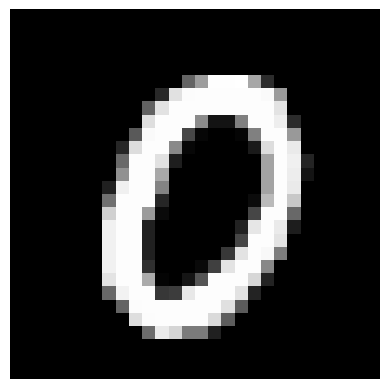

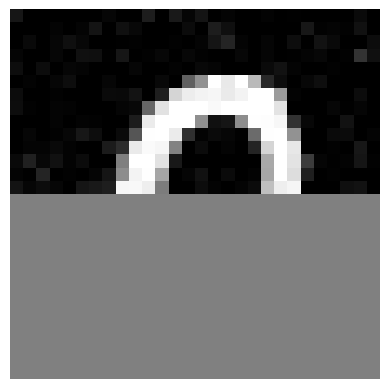

In [149]:
X_stored = X_train[:, :784]
X_retrieved = X_stored[10].view(28, 28)
# Determine the number of rows and columns in the matrix
rows, cols = 28, 28

# Calculate the number of rows to set to white (20% of the total rows)
rows_to_whiten = int(0.5 * rows)

X_test_whitened = X_retrieved.view(28, 28)
X_test_whitened = add_gaussian_noise(X_test_whitened, 0, 0.1)
X_test_whitened[-rows_to_whiten:] = 0
plt.imshow(X_retrieved, cmap='gray', vmin=-1, vmax=1)
plt.axis('off')  # Hide axis labels and ticks
plt.show()
# Plot the image with the desired pixel range
plt.imshow(X_test_whitened, cmap='gray', vmin=-1, vmax=1)
plt.axis('off')  # Hide axis labels and ticks
plt.show()

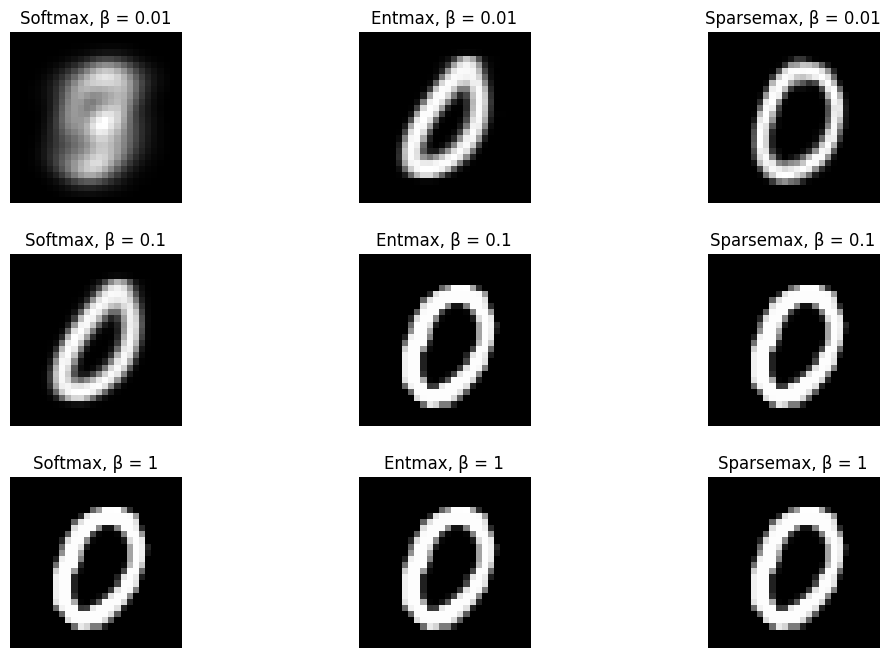

In [150]:
# Define beta values
betas = [0.01, 0.1, 1]

# Define activation function names
activation_functions = ["Softmax", "Entmax", "Sparsemax"]

# Create a figure with rows for beta values and columns for activation functions
num_rows = len(betas)
num_cols = len(activation_functions)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, beta in enumerate(betas):
    for j, activation in enumerate(activation_functions):
        ax = axes[i, j]

        if activation == "Softmax":
            model = HopfieldNet(X_stored, 1.0, beta, 128)
        elif activation == "Entmax":
            model = HopfieldNet(X_stored, 1.5, beta, 128)
        elif activation == "Sparsemax":
            model = HopfieldNet(X_stored, 2.0, beta, 128)

        Q = model(X_test_whitened.flatten().view(784, 1))
        Q = Q.T.view(28, 28)

        ax.imshow(Q, cmap='gray')
        ax.axis('off')
        ax.set_title(f"{activation}, β = {beta}")

plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

Metastable evaluation

In [151]:
def cccp(X, Q, alpha, beta, num_iters):
    Xi = Q
    for _ in range(num_iters):
        P = entmax(X @ Xi *beta, alpha=alpha, dim=0)
        Xi = X.T @ P

    return P


In [152]:
num_iters = 128
eps = 1e-2
device = torch.device("cuda:" + "1")
X_train = X_train.to(device)
X_test = X_test.to(device)
n_samples = X_test.shape[0]
N = X_train.shape[0]
ctrs_total = {}
for beta in [0.1, 1, 10]:
    ctrs = []
    for alpha in [1, 1.5, 2]:

        P = cccp(X_train, X_test.T, alpha, beta, num_iters)
        eps_ = eps if alpha == 1 else 0
        sizes = (P > eps_).sum(dim=0)

        ctr = Counter(sizes.tolist())
        ctrs.append(ctr)

        # print([(k, ctr[k], ctr[k]/n_samples) for k in range(1, N+1)])

    ctrs_total[str(beta)] = ctrs
    print(f"Beta: {beta:.1f}")  
    for k in range(0, 10):

        print(f"{k} & "
                f"{ctrs[0][k]/n_samples*100:.1f} & "
                f"{ctrs[1][k]/n_samples*100:.1f} & "
                f"{ctrs[2][k]/n_samples*100:.1f} \\\\")
    print("\n")

Beta: 0.1
0 & 88.8 & 0.0 & 0.0 \\
1 & 1.3 & 78.9 & 92.6 \\
2 & 0.4 & 5.5 & 4.4 \\
3 & 0.1 & 2.1 & 1.6 \\
4 & 0.1 & 0.9 & 0.6 \\
5 & 0.0 & 0.5 & 0.8 \\
6 & 0.1 & 0.2 & 0.1 \\
7 & 0.0 & 0.2 & 0.0 \\
8 & 0.0 & 0.1 & 0.0 \\
9 & 0.0 & 0.3 & 0.0 \\


Beta: 1.0
0 & 0.0 & 0.0 & 0.0 \\
1 & 98.6 & 100.0 & 100.0 \\
2 & 0.9 & 0.0 & 0.0 \\
3 & 0.3 & 0.0 & 0.0 \\
4 & 0.1 & 0.0 & 0.0 \\
5 & 0.1 & 0.0 & 0.0 \\
6 & 0.0 & 0.0 & 0.0 \\
7 & 0.0 & 0.0 & 0.0 \\
8 & 0.0 & 0.0 & 0.0 \\
9 & 0.0 & 0.0 & 0.0 \\


Beta: 10.0
0 & 0.0 & 0.0 & 0.0 \\
1 & 100.0 & 100.0 & 100.0 \\
2 & 0.0 & 0.0 & 0.0 \\
3 & 0.0 & 0.0 & 0.0 \\
4 & 0.0 & 0.0 & 0.0 \\
5 & 0.0 & 0.0 & 0.0 \\
6 & 0.0 & 0.0 & 0.0 \\
7 & 0.0 & 0.0 & 0.0 \\
8 & 0.0 & 0.0 & 0.0 \\
9 & 0.0 & 0.0 & 0.0 \\




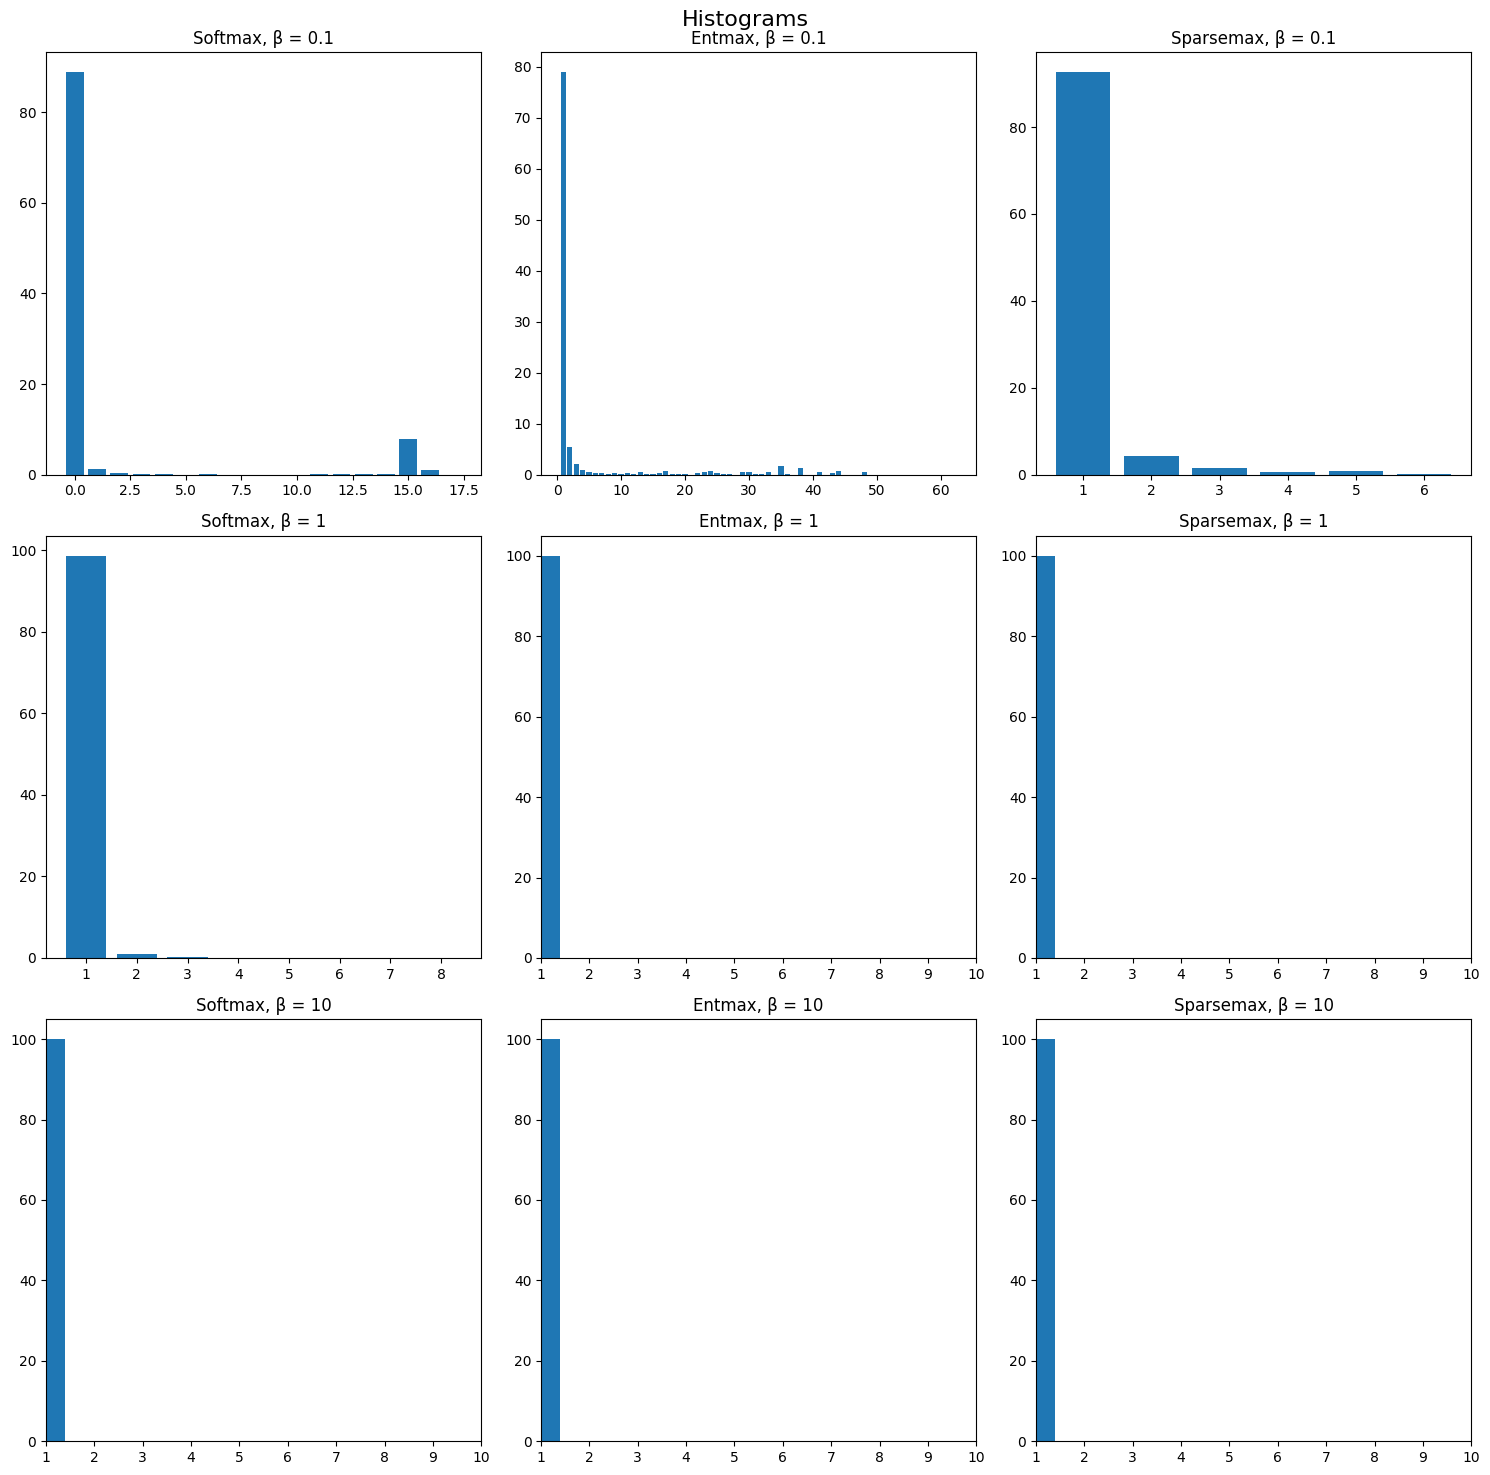

In [153]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
labels = ["Softmax", "Entmax", "Sparsemax"]
# Iterate through the dictionaries and create histograms in the subplots
for i, (key, counters) in enumerate(ctrs_total.items()):
    row = i // 3

    x_axis_range = (1, 10)  # Adjust the range as needed
    for j, counter in enumerate(counters):
        ax = axes[i,j]
        x = list(counter.keys())
        y = list(counter.values())
        bin_edges = np.arange(min(x) - 0.5, max(x) + 1.5, 1)
        y = [100 * num / sum(y) for num in y]

        ax.hist(x, bins=bin_edges, weights=y, align='mid', rwidth=0.8)
        ax.set_title(f'{labels[j]}, β = {key}')
        # Set x-axis to display integers only
        if len(y) == 1:
            ax.set_xlim(x_axis_range)
# Set labels and title for the entire figure
fig.suptitle('Histograms', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()